# Lecture 5 Errors, Files, Logging, Libraries, Imports

## Context Manager

Одна із поширених проблем, з якими стикаються в програмуванні є розподілення зовнішних ресурсів (managing external resources). Наприклад відриття файлу, устаткування мереживих зв'язків, отримання доступу до баз даних і так далі.

Інколи, програми забирають якісь ресурси (пам'ять, процесорний час), навіть якщо більше в програмній процедурі ці ресурси не використовуються. 

Наприклад проблема `memory leak`, процес в якому програма постійно запрашує ті чи інші ресурси, не віддаючи їх по закінченню роботи з ними, і кількість потрібної пам'яті поступово збількшується.

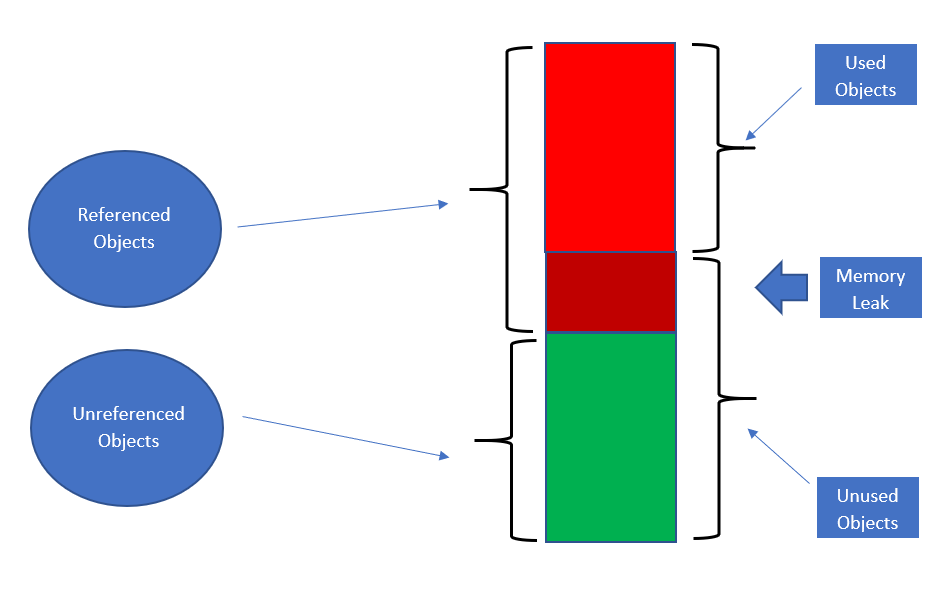

Для безпроблемної роботи з ресурами, необхідно розділяти на фазу ініціації (setup phase) та фаза закінчення (teardown phase). Тобто, для роботи з будь якім ресурсом ми маємо: 

* отримати доступ до нього
* провести необхідну процедуру
* закінчити роботу з ресурсом та "визволити" його

Як приклад - робота з файлом:

* відкриваємо файл
* робимо процедуру (наприклад - читання)
* зачиняємо файл

В пайтон робота з файлами реалізується завдяки білт-іну `open`:

In [ ]:
fp = open("myfile.txt", "w"):
fp.write("hello!")
fp.close()

Детальніше про `open` можна прочиати [тут](https://docs.python.org/3/library/functions.html#open)

Проте, така робота з файлами не гарантує, що файл буде закрито на прикінці роботи з ним, в сенсі, що розробник, може просто напросто "забути" закрити файл, і ресурс що був виділений на цей файл при його відкритті, залишиться в програмі до момента її закриття.

In [ ]:
fp = open("myfile.txt", "r")
fp.readlines()

В Пайтон існує два загальних підхода до вирішення роботи з ресурсом - перше - контекст менеджер, або конструкція `with`, друге - робота через `try... finally`, обидва цих підхода ми роздивимося, проте почнемо з контекст менеджера.

Контекстиний менеджер `with` дозволяє виконати ту чи іншу процедуру, знаходячись в блоці контестного менеджара, що значить наступне - при старті контекстного менеджера ви виділяєте ресурси, пілся того, як процедура закінчилася, контекстний менеджер автоматично викликає закінчення роботи з ресуром.

Загальна конструкція `with` виглядає наступним чином:

```
with <expression> as <target_var>:
    ...perform procedure...
```

Повертаючись до прикладу роботи з файлом, така конструкція буде виглядати наступним чином:

In [ ]:
with open("myfile.txt", "w") as fp:
    fp.write("Hello!")

Користуючись такою конструкцією, після закінчення процедури, контекстний менеджер визволить ресурси, закриє файл та віддасть ресурси обратно в систему.

Що насправді робить контестний менеджер `with`? Насправді, в пайтон, доволі легка і зрозуміла імплементація цього процесу, виглядає вона в наступному:

Об'єкт, що повертає `<expression>` має імплементувати два магічних метода:
* `__enter__()` - що викликається в момент коли ми маємо зайти в контекстний менеджер
* `__exit__()` - що викликається в момент, коли процедура закінчилася

Як приклад:

In [5]:
class T:

    def __enter__(self):
        print("[1] hi we have done some set up inside enter method")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        print("[3] and then the procedure ended and we are providing some procedures of the end")
        
    def method(self):
        print("[2] - executing a method")

In [6]:
with T() as t:
    t.method()

[1] hi we have done some set up inside enter method
[2] - executing a method
[3] and then the procedure ended and we are providing some procedures of the end


Давайте просто для розуміння перепишемо відкривання файлу в нашому класі:

In [13]:
class FileOpener:
    
    def __init__(self, path, readmode):
        self._fp = open(path, readmode)
    
    def write_data(self, data):
        self._fp.write(data)
        print("a data is written")
    
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self._fp.close()

In [14]:
path = "myfile.txt"
readmode = "w"

with FileOpener(path, readmode) as fo:
    print(fo.__class__)
    fo.write_data("abc")

<class '__main__.FileOpener'>
a data is written


Тобто, конструкція `with` очікує вираз, що поверне об'єкт, в якого імплементовані два цих метода, викликає метод `__enter__` при початку, та `__exit__` наприкінці процедури.

Контекстний менеджер, в свою чергу, підтримує можливість використання 2+ виразів, що повернуть об'єкт імплементованим контекстним менеджером, наприклад:

In [15]:
with T() as t1, T() as t2, T() as t3:
    print("I can handle even more")

[1] hi we have done some set up inside enter method
[1] hi we have done some set up inside enter method
[1] hi we have done some set up inside enter method
I can handle even more
[3] and then the procedure ended and we are providing some procedures of the end
[3] and then the procedure ended and we are providing some procedures of the end
[3] and then the procedure ended and we are providing some procedures of the end


## Помилки

Як ви вже напевно бачили, в `python` є доволі багато імплементованих помилок, з деякими ви вже стикались `SyntaxError`, `IndexError`, `ValueError` і так далі.

In [16]:
print(0 / 0)

ZeroDivisionError: division by zero

Ви також, в свою чергу, можете викликати помилки самостійно в своєму коді, при якихось перевірках, невірних даних, тощо, наприклад:

In [18]:
def foo(arg1: int, arg2: int):
    if not isinstance(arg1, int):
        raise ValueError(f"arg1 type is {type(arg1)}, but int expected")
    if not isinstance(arg2, int):
        raise ValueError(f"arg1 type is {type(arg2)}, but int expected")
    
    return arg1 + arg2

In [19]:
foo("arg", 5)

ValueError: arg1 type is <class 'str'>, but int expected

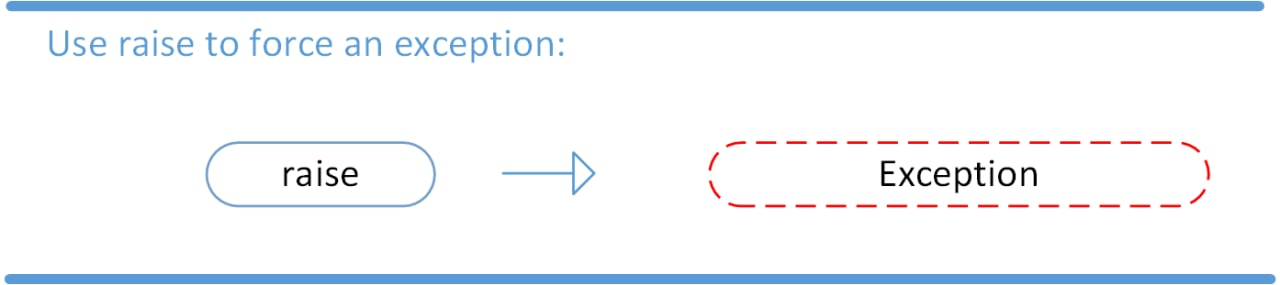

Ще одним варіантом перевірки тої чи іншої кондиції є `assert`, який підіймає `AssertionError`, якщо контрускія яка попала всередину `assert` не є `True`:

In [20]:
def foo(arg1: int, arg2: int):
    assert(isinstance(arg1, int))
    assert(isinstance(arg2, int))
    
    return arg1 + arg2

In [21]:
foo("arg", 5)

AssertionError: 

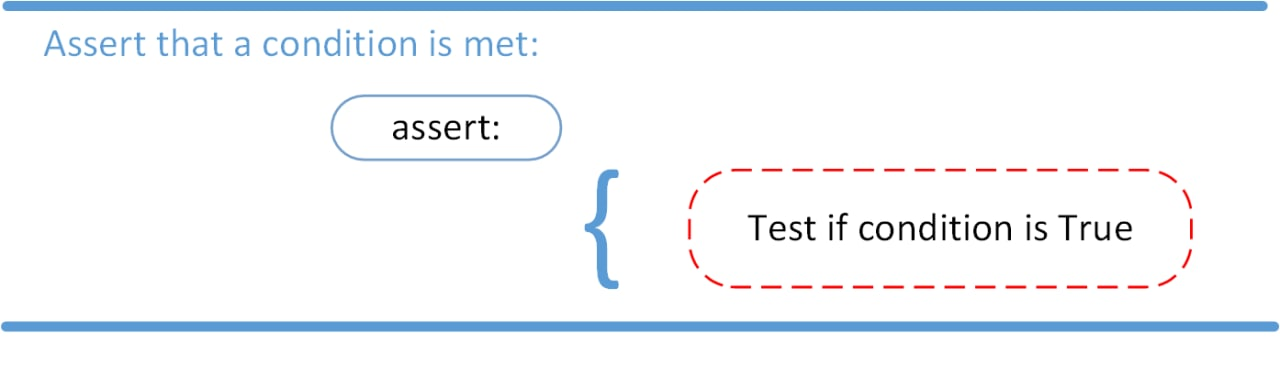

Асерти, насамперед необхідні для само-контролю, якщо користуватися асератами в продакшн коді, то деякі компілятори можуть просто пропускати ці асерти, і через це програма не буде їх виконувати, проте ось вам приклад використання асерту:

In [22]:
import sys
assert('win32' == sys.platform)

**Обробка помилок**

В пайтоні є можливіть обробляти помилки, які трапилися під час виконання вашої програми, тобто, в якийсь момент часу ви очікуєте, що десь може з'явитися помилка. Якщо помилка не була оброблена, то програма завершить свою роботу. 

Наприклад - якщо ваша програма має працювати постійно - якийсь умовний бот чи сервер, необроблена помилка в коді призведе до закінчення роботи програми (за умов якщо не використовується будь-яка форма паралелізму)

Початкова (необхідно-достатня конструкція) включає в себе ключове слово `try`, після якого виконується блок інструкцій, та `except`, у випадку, якщо помилка сталася:

In [23]:
try:
    1 / 0
except:
    print("some error happend")

some error happend


Таким чином, ваша помилка вважається обробленною та програма продовжує своє виконання не дивлячись на те що помилка сталася.

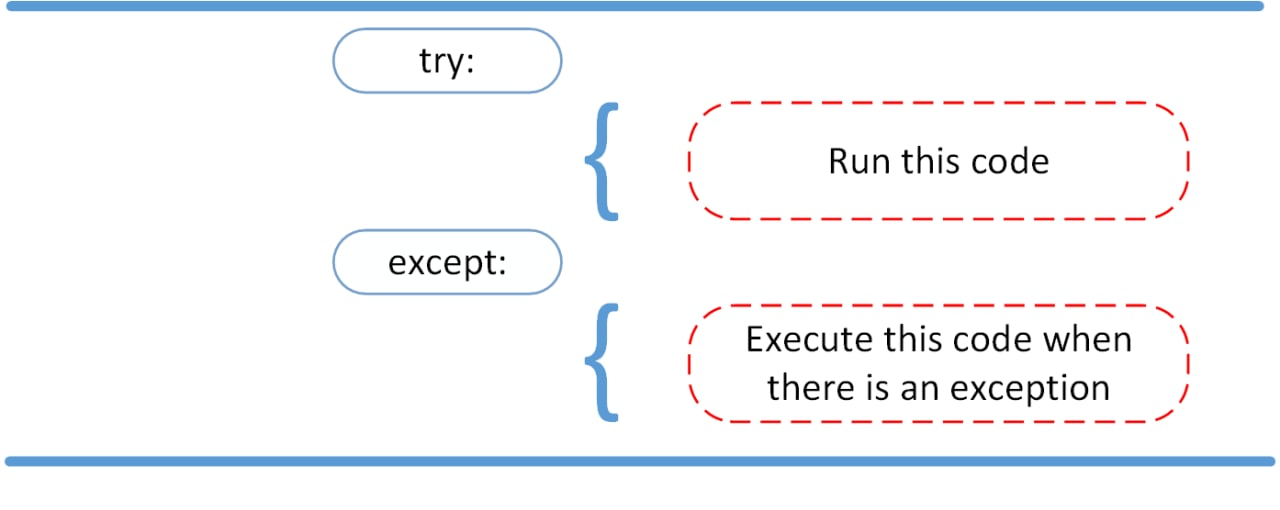

Далі - в вас є можливість вказати яка саме помилка має статися, передаючи об'єкт класа помилки справа від `except`:

In [24]:
def foo():
    raise ValueError("This function is always raising errors!")
    
try:
    foo()
except ValueError:
    print("value error handeled")

value error handeled


Всі помилки в мові програмування наслідуються від об'єкту класу `Exception`, який в свою чергу наслідується від `BaseException`:

In [25]:
Exception.mro()

[Exception, BaseException, object]

In [26]:
ValueError.mro()

[ValueError, Exception, BaseException, object]

Також, у вас є можливість передати інстанс помилки в якості змінної, корситуючись конструкцією `as`:

In [29]:
try:
    foo()
except ValueError as ve:
    print(f"value error handeled, got {ve} \n"
          f"with id {id(ve)} and type {type(ve)}")

value error handeled, got This function is always raising errors! 
with id 1860101195472 and type <class 'ValueError'>


Ви також, в свою чергу можете задавати процедури, які трапляються у випадку декількох потенційних помилок:

In [30]:
try:
    foo()
except AssertionError as ae:
    print("assert error")
except ValueError:
    print("value error")

value error


Ви також, можете скористатися наступною конструкцією:

In [31]:
try:
    foo()
except Exception:
    print("any exception happened")

any exception happened


Проте, оскількі в `Exception` потрапляють взагалі ВСІ помилки, то використання в такому варіанті призведе до неочікуванної поведінки:

In [32]:
try:
    foo()
except Exception:
    print("any exception happened")
except ValueError:
    print("val error")

any exception happened


Тому використання загальної помилки треба використовувати лише в кінці, коли ви не очікуєте що якась помилка трапиться, але все одно вирішили додати її, щоб програма не зупинилася:

In [33]:
try:
    foo()
except AssertionError as ae:
    print("assert error")
except ValueError:
    print("value error")
except Exception:
    print("general exeption happened")

value error


Також, у вас є можливість створювати власні класи помилок, наслідуючись від `Exception`:

In [36]:
class MyException(Exception):
    pass

try:
    raise MyException
except MyException:
    print("yup")

yup


Такий функціонал дозволяє створювати свої власні помилки, коли необхідно обробити якусь поведінку програми, і вам необхіжно підняти саме цю помилку (приклади помилок які я використовую в боті):

In [37]:
class InnerNotebookError(Exception):
    def __init__(self, msg):
        super(InnerNotebookError, self).__init__(msg)


class SysLibUsedException(Exception):
    def __init__(self, msg):
        super(SysLibUsedException, self).__init__(msg)


class GraderException(Exception):
    def __init__(self, msg):
        super(GraderException, self).__init__(msg)


class TimePassedException(Exception):
    def __init__(self, msg):
        super(TimePassedException, self).__init__(msg)


Далі, конструкція `try, except` може бути розвинута в наступну форму:

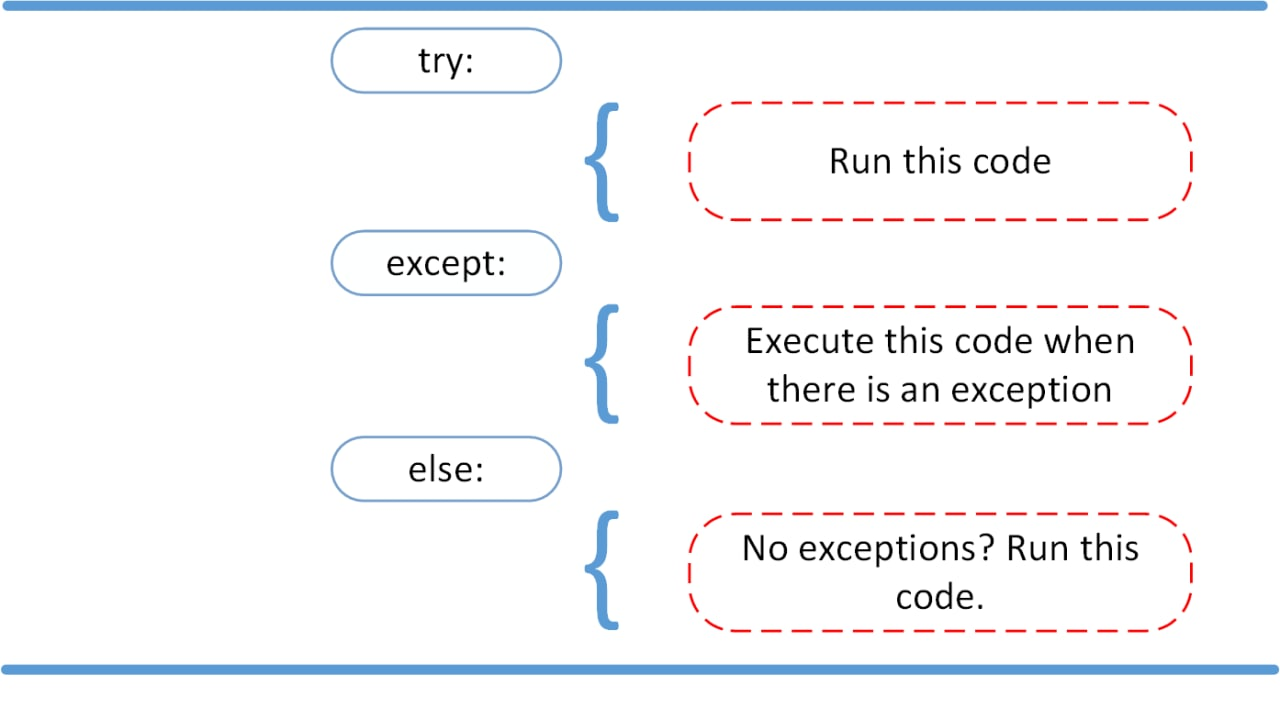

In [38]:
try:
    assert(5 == 5)
except AssertionError:
    print("assertion error happened")
else:
    print("no error happened")

no error happened


Останнім елементом конструкції обробки помилок може бути `finally`, який виконується ЗАВЖДИ, незважаючи на те, чи була перехоплена помилка, чи не було:

In [41]:
try:
    assert(5 == 5)
except AssertionError:
    print("assertion error happened")
else:
    print("no error happened")
finally:
    print("enterring finaly construction")

no error happened
enterring finaly construction


## Libraries

Ви напевно вже бачили наступні конструкцію:

In [43]:
import random
import math

Це система імпортів. Імпорти - це ключове слово, яке дозволяє одному **модулю** отримати дані з іншого **модуля**. Тобто дати можливіть одному файлу виконувати код із іншого файла (в першому наближенні)

Наприклад, створемо новий файл, і покладемо в нього якийсь текст функції:

In [45]:
p = "test.py"
code = """
def foo():
    print("Im a code from another module, yay!")
"""

with open(p, "w") as fp:
    fp.writelines(code)

Далі - продивимося, що є в нашому неймспейсі, користуючись білтін `dir`:

In [47]:
str(dir())

"['FileOpener', 'GraderException', 'In', 'InnerNotebookError', 'MyException', 'Out', 'SysLibUsedException', 'T', 'TimePassedException', '_', '_25', '_26', '_46', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i3', '_i30', '_i31', '_i32', '_i33', '_i34', '_i35', '_i36', '_i37', '_i38', '_i39', '_i4', '_i40', '_i41', '_i42', '_i43', '_i44', '_i45', '_i46', '_i47', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'code', 'exit', 'fo', 'foo', 'fp', 'get_ipython', 'math', 'p', 'path', 'quit', 'random', 'readmode', 'sys', 't', 't1', 't2', 't3']"

Далі, спробуємо імпортувати нашу функцію, яку ми створили в окремому файлі:

In [48]:
import test

In [49]:
test.foo()

Im a code from another module, yay!


In [50]:
str(dir())

"['FileOpener', 'GraderException', 'In', 'InnerNotebookError', 'MyException', 'Out', 'SysLibUsedException', 'T', 'TimePassedException', '_', '_25', '_26', '_46', '_47', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i3', '_i30', '_i31', '_i32', '_i33', '_i34', '_i35', '_i36', '_i37', '_i38', '_i39', '_i4', '_i40', '_i41', '_i42', '_i43', '_i44', '_i45', '_i46', '_i47', '_i48', '_i49', '_i5', '_i50', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'code', 'exit', 'fo', 'foo', 'fp', 'get_ipython', 'math', 'p', 'path', 'quit', 'random', 'readmode', 'sys', 't', 't1', 't2', 't3', 'test']"

Як ви бачите, ми імпортували цей модуль як об'єкт `test`, та можемо звернутися до нього як до модуля, (об'єкта) і викликати метод `.test`, який насправдні є функцією.

Команда імпорт створила об'єкт `module`, звертаючись до якого ми можемо викликати всі функції, які були в ньому.

In [52]:
type(test)

module

Також, у вас є можливість імпортувати окремі функції та частини коду з того чи іншого модуля, користуючись кейвордом `from <modulename> import <object_name>`

In [53]:
from test import foo

In [54]:
foo()

Im a code from another module, yay!


В мові програмування `python` вже є передустановлені модулі, які називаються `built-in packages`, деякі з них ви вже бачили, деякі ні, їх доволі багато, повний список знаходиться [тут](https://docs.python.org/3/library/)

Також, є можливість інсталювати додаткові пакети, користуючись менеджером пакетів `pip`, який знаходить за вас потрібний вам пакет та встановлює його в ваш `environment`, після установки ви можете ним користуватися, детальніше [тут](https://www.w3schools.com/python/python_pip.asp)

## Logging

Одним із перших модулів, який ми з вами роздивимось буде модуль логгінга. Він потрібен майже завжди, при умов якщо ви пишете будь-яку програму. Що він робить? `Logging` видає ту чи іншу строку в файл, за замовченням цей файл це `system out`, так само як і `print`, і ви можете побачити вашу строку в консолі або юпітері:

In [55]:
print("hi")

hi


In [56]:
import logging

logging.basicConfig(
    format="%(asctime)s [%(levelname)s] |%(name)s| %(message)s", level=logging.INFO, datefmt="%d-%m-%Y",
)

log = logging.getLogger("MyLog")

In [57]:
log.info("this is a hi from logging")

13-11-2022 [INFO] |MyLog| this is a hi from logging


Проте, на відміну від `print` - логінг дозволяє кастомізувати ваші системні виводи, додати йому рівень потреби, ім'я (хто власне викликав цей лог, в який час і так далі)

Така система дозволяє вам набагато краще зрозуміти хто де і як викликав цю помилку, уявіть, якщо б в дивилися лог своєї программи, яка працює декілька днів, а вся консоль забита принтами і взагалі не зрозуміло що де коїться.

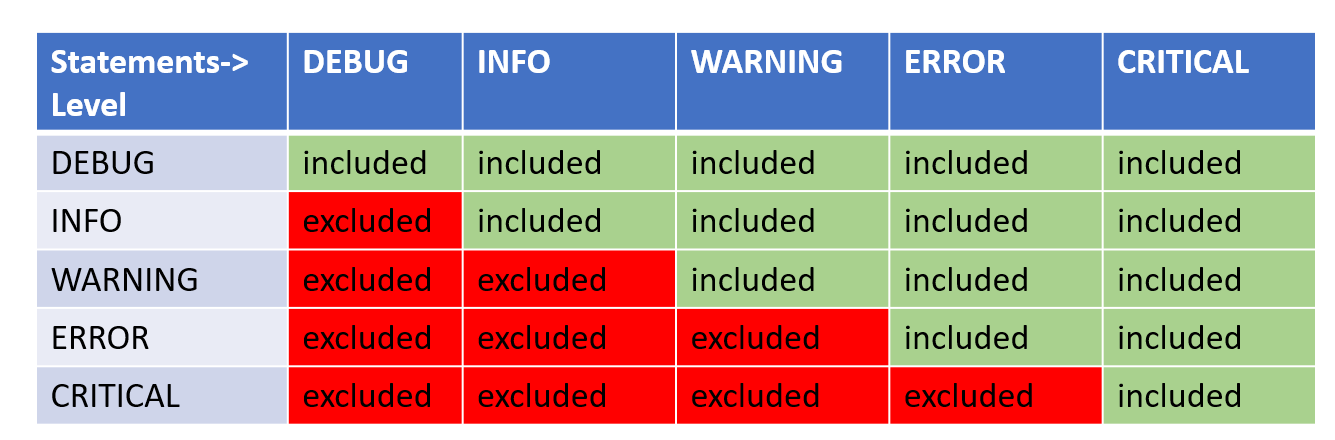